# jitcsim tutorial

### Simulation of the Kuramoto model.
The parameters are coupling and the initial angular frequencies.
The initial phase also could be changed in repeated simulations.
The output is plotting the time average of order parameter vs 
strength of the coupling.
This is exampel is run in parallel using multiprocessing.

In [1]:
import numpy as np
from numpy import pi
from time import time
import networkx as nx
from random import randint
from multiprocessing import Pool
from jitcsim.utility import flatten
from numpy.random import uniform, normal
from jitcsim.visualization import plot_order
from jitcsim.models.kuramoto import Kuramoto_II

In [2]:
np.random.seed(1)
N = 50                                          # number of nodes
num_ensembles = 100                             # number of ensembles
num_processes = 4                               # number of processes

alpha0 = 0.0                                    # frustration
omega0 = normal(0, 0.1, N)                      # initial angular frequencies
initial_state = uniform(-pi, pi, N)             # initial phases
adj = nx.to_numpy_array(nx.complete_graph(N),
                        dtype=int)              # adjacency matrix

parameters = {
    'N': N,
    'adj': adj,
    't_initial': 0.,
    "t_final": 100,
    't_transition': 2.0,
    "interval": 1.0,                    # time interval for sampling
    'initial_state': initial_state,
    'integration_method': 'dopri5',
    "alpha": alpha0,
    'control': ['coupling', 'omega'],
    "use_omp": False,
    "output": "data",
    "modulename": "km"
}

In [3]:
def run_for_each(coupl):

    """
    run the simulation for each coupling
    The initial state and frequencies are changed.
    """

    omega0 = normal(0, 0.1, N)
    controls = flatten([[coupl], omega0])
    I = Kuramoto_II(parameters)
    I.set_initial_state(uniform(-pi, pi, N))
    data = I.simulate(controls)
    x = data['x']
    order = np.mean(I.order_parameter(x))

    return order


In [7]:
parameters["modulename"] = "km{}".format(randint(0, 1e6)) # to avoid modulename error
sol = Kuramoto_II(parameters)
compile_time = time()
sol.compile()
print("Compile time : {:.3f} secondes.".format(time() - compile_time))

saving file to data/km968481.so
Compile time : 5.379 secondes.


In [8]:
start_time = time()
couplings = np.arange(0, 0.8, 0.05) / (N-1)

par = []
for i in range(len(couplings)):
    for j in range(num_ensembles):
        par.append(couplings[i])

with Pool(processes=num_processes) as pool:
    orders = (pool.map(run_for_each, par))
orders = np.reshape(orders, (len(couplings), num_ensembles))

print("Simulation time: {:.3f} seconds".format(time()-start_time))


Simulation time: 27.188 seconds


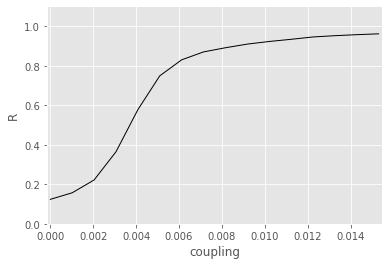

In [6]:
# plotting time average of the order parameters vs coupling
plot_order(couplings,
           np.mean(orders, axis=1),
           filename="data/05.png",
           ylabel="R", 
           xlabel="coupling",
           close_fig=False);
